## Classification and cutouts around Fornax 

Two level classification of the objects around Fornax

Then we get and inspect the cutouts of the objects classified as LSBGs

In [1]:
# Import stuff
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

%matplotlib inline
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    #plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [3]:
from Train_set import supervised
y_dat, X_dat = supervised()

In [4]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_dat, y_dat, train_size = 0.75, random_state = 42 )

# =======================================================
# Import the Support Vector Classifier
from sklearn.svm import SVC
svc = SVC(kernel='rbf')

//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
from sklearn.grid_search import GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 50, 100, 150,200, 250, 300],
              'gamma': [0.0001, 0.0005, 0.0006, 0.0007, 0.0008,0.001, 0.003,0.005]}
grid = GridSearchCV(svc, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


CPU times: user 3.66 s, sys: 87.9 ms, total: 3.75 s
Wall time: 5.46 s
{'C': 200, 'gamma': 0.003}


In [6]:
svc_2 = SVC(C=200, kernel='rbf', gamma=0.003)
svc_2.fit(Xtrain, ytrain)
print(svc_2.score(Xtrain,ytrain))
print(svc_2.score(Xtest,ytest))

0.9027484143763214
0.8955696202531646


In [7]:
from Region_Fornax import feat_return_Forn
X_feat, dnf_zmean, dnf_zmc, RA, DEC = feat_return_Forn()

In [8]:
redshift_cut = (dnf_zmean>0)&(dnf_zmean<0.2)&(dnf_zmc>0)

X_ft_cut = X_feat[redshift_cut]
RA_cut = RA[redshift_cut]; DEC_cut = DEC[redshift_cut]
dnf_zmean_cut = dnf_zmean[redshift_cut]
print(np.shape(X_ft_cut))

(4454, 16)


In [9]:
# Predict
y_pred = svc_2.predict(X_ft_cut)
# ===============================================
# ===============================================
a = y_pred[y_pred==1]

print(len(a))

2185


In [10]:
# Keep the positive here
X_ft_cut_pos = X_ft_cut[y_pred==1]
RA_pos = RA_cut[y_pred==1]; DEC_pos = DEC_cut[y_pred==1]
dnf_zmean_pos = dnf_zmean_cut[y_pred==1]

# Unify the Features matrix
X_feat_tot = np.zeros((len(a),17))
X_feat_tot[:,0:16] = X_ft_cut_pos
X_feat_tot[:,16] = dnf_zmean_pos

#### Import for the second classification

In [11]:
from For_2nd_Classification import supervised as supervised_2nd
y_labels_2, X_features_2 =  supervised_2nd()

In [12]:
Xtrain_2, Xtest_2, ytrain_2, ytest_2 = train_test_split(X_features_2, y_labels_2, train_size = 0.85, random_state = 42 )

In [13]:
svc = SVC(kernel='rbf')
param_grid = {'C': [0.01, 0.1, 1, 10, 50, 100, 150,200, 250, 300],
              'gamma': [0.0001, 0.0005, 0.0006, 0.0007, 0.0008,0.001, 0.003,0.005]}
grid = GridSearchCV(svc, param_grid)

%time grid.fit(Xtrain_2, ytrain_2)
print(grid.best_params_)

CPU times: user 2.13 s, sys: 17.3 ms, total: 2.14 s
Wall time: 2.16 s
{'C': 200, 'gamma': 0.005}


In [14]:
svc_3 = SVC(C=200, kernel='rbf', gamma=0.005)
svc_3.fit(Xtrain_2, ytrain_2)
print(svc_3.score(Xtrain_2,ytrain_2))
print(svc_3.score(Xtest_2,ytest_2))

0.92375
0.9154929577464789


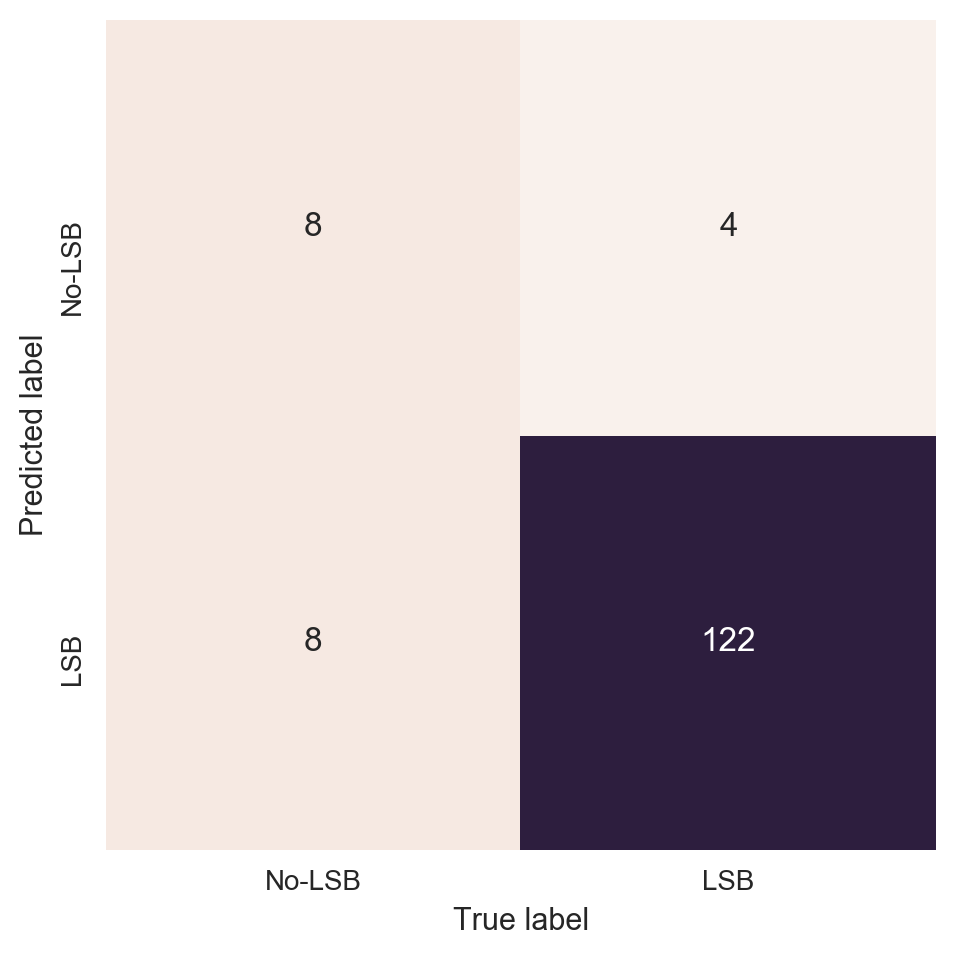

In [15]:
target_names = ['No-LSB', 'LSB']
y_fit = svc_3.predict(Xtest_2)
import seaborn as sns
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest_2, y_fit)
sns.heatmap(mat.T, square = True, annot=True, fmt='d', cbar=False, 
           xticklabels= target_names,
           yticklabels= target_names)

plt.xlabel('True label')
plt.ylabel('Predicted label');

#### Now fit the for the region around Fornax

In [16]:
y_forn_pred = svc_3.predict(X_feat_tot)

a = len(y_forn_pred[y_forn_pred==1])
print(a)

2110


In [17]:
RA_posit = RA_pos[y_forn_pred==1]
DEC_posit = DEC_pos[y_forn_pred==1]
X_posit = X_feat_tot[y_forn_pred ==1]

In [18]:
np.savetxt('Fornax.dat', np.c_[RA_posit, DEC_posit], fmt='%.6f %.6f')

#### Clustering

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(2) #Initialize a KMeans model with three clusters

In [20]:
# Fit and predict the labels of the clusters
labels = kmeans.fit_predict(X_posit)

# Get the three cluster centers
centers = kmeans.cluster_centers_

print(labels[0:200])

[0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]


In [21]:
# Category 1
RA_cat_1 = RA_posit[(labels==0)]
DEC_cat_1 = DEC_posit[(labels==0)]

# Category 2

RA_cat_2 = RA_posit[(labels==1)]
DEC_cat_2 = DEC_posit[(labels==1)]


print(len(RA_cat_1))
print(len(RA_cat_2))


1907
203


In [22]:
np.savetxt('Fornax_cat_1.dat', np.c_[RA_cat_1, DEC_cat_1], fmt='%.6f %.6f')
np.savetxt('Fornax_cat_2.dat', np.c_[RA_cat_2, DEC_cat_2], fmt='%.6f %.6f')


In [23]:
print(centers[0])

[19.71490797 19.3099433  19.14867332  0.40496467  0.56623465  0.40496467
  3.31677338  3.21435349  3.15965349 24.90190596 24.40982168 24.19419731
 23.22752989 22.71586717 22.42401132  0.26219528  0.10330174]


In [24]:
print(centers[1])

[18.09386823 17.53827537 17.33688486  0.55559286  0.75698337  0.55559286
  7.75932169  7.76390629  7.69724256 25.18803771 24.63615185 24.40403629
 23.05012676 22.46869452 22.15793941  0.28957023  0.07377494]


### Some t-SNE embeddings 

In [25]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_posit)

In [26]:
print(np.shape(X_embedded))

(2110, 2)


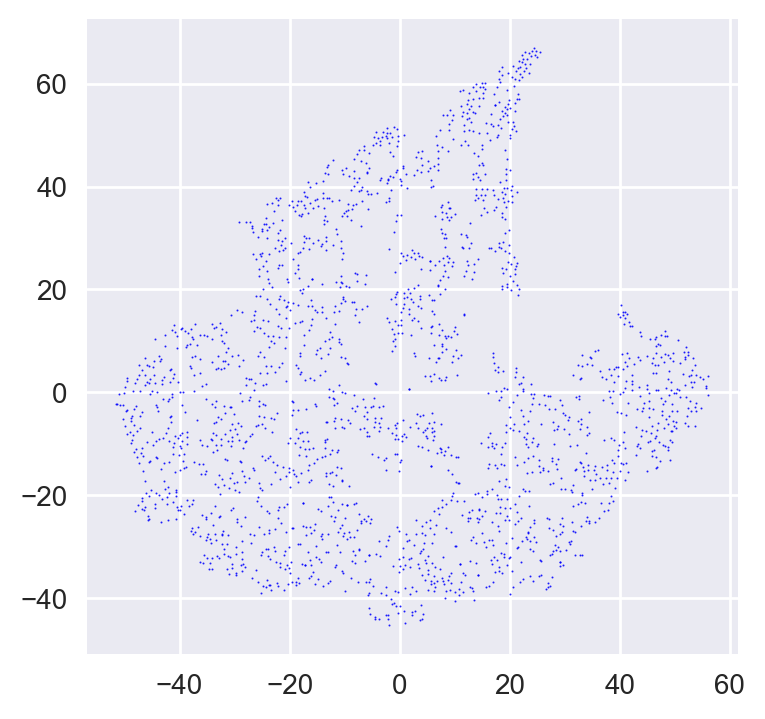

In [27]:
fig = plt.figure(figsize=(4.2,4.2))

plt.scatter(X_embedded[:,0],X_embedded[:,1],c='blue', s=0.2, alpha=0.7)

plt.show()

### Plot their positions

In [30]:
RAh, RAm, RAs, DECd,DECm, DECs = np.loadtxt("Reflex_RADEC.dat",  unpack=3, usecols=[1,2,3,4,5,6])

print(len(RAh))

447


In [31]:
RA_reflex = RAh*15.0 + RAm/4.0 + RAs/240.0  # Right ascension in degrees 

# Get signs 
sig = np.sign(DECd)
sig[32]=sig[104]=sig[245]=sig[288]=sig[436]=1
sig[174]=sig[175]=sig[272]=sig[289]=-1

DEC_reflex = sig*(abs(DECd) + DECm/60.0 + DECs/3600.0)

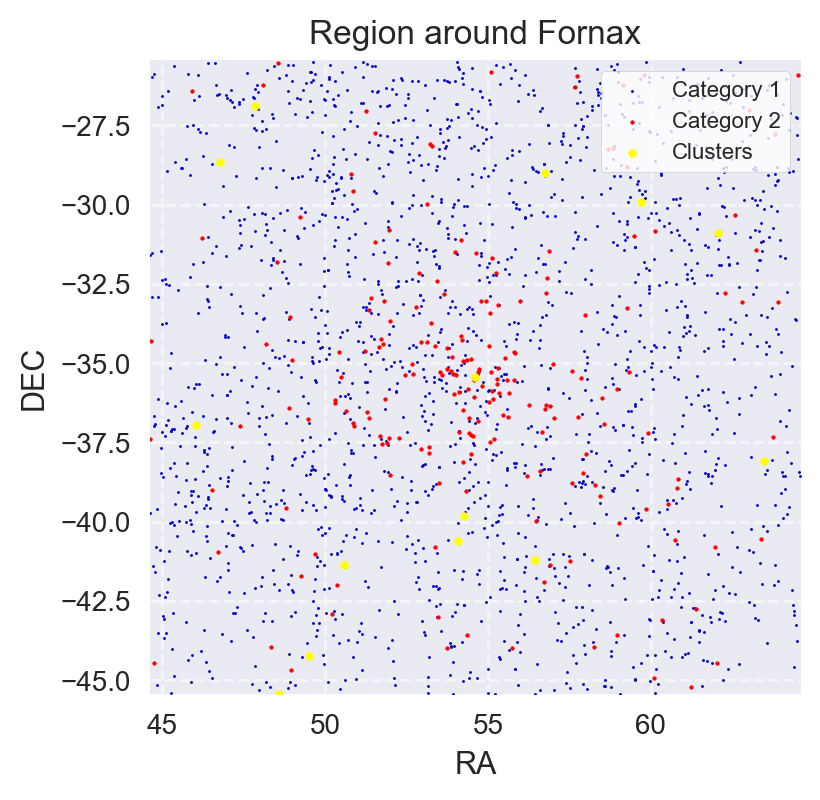

In [41]:
fig = plt.figure(figsize=(4.2,4.2))
plt.scatter(RA_cat_1, DEC_cat_1, c='mediumblue', s=0.5,  label='Category 1')
plt.scatter(RA_cat_2, DEC_cat_2, c='red', s=1.5,  label='Category 2')
plt.scatter(RA_reflex, DEC_reflex, c='yellow', s=7.4, label='Clusters')


plt.xlabel('RA'); plt.ylabel('DEC')
plt.grid(ls='--', alpha=0.6)
plt.xlim(44.61625,64.61625)
plt.ylim(-45.44833,-25.44833)
plt.legend(frameon=True, loc='upper right', fontsize=8, facecolor='w')
plt.title('Region around Fornax')
plt.show()

### Auto-correlation functions

In [194]:
import treecorr
import fitsio

In [195]:
# Create catalog. For now, we choose our catalog to be the objects classified as real LSB objects 
cat1 = treecorr.Catalog(ra=RA_cat_1, dec=DEC_cat_1, ra_units='deg', dec_units='deg')
# Create a second catalog, using the objects in region 2 (those classfied as real LSB objects)
cat2 = treecorr.Catalog(ra=RA_cat_2, dec=DEC_cat_2, ra_units='deg', dec_units='deg')

In [196]:
dd_1 = treecorr.NNCorrelation(min_sep=0.1, max_sep=10, bin_size=0.2, sep_units='degrees')
dd_1.process(cat1)

In [197]:
leng_1 = len(RA_cat_1)
ra_min = np.min(cat1.ra)
ra_max = np.max(cat1.ra)
dec_min = np.min(cat1.dec)
dec_max = np.max(cat1.dec)

rand_ra_1 = np.random.uniform(ra_min, ra_max, leng_1) #Random RA
rand_sindec_1 = np.random.uniform(np.sin(dec_min), np.sin(dec_max), leng_1)
rand_dec_1 = np.arcsin(rand_sindec_1)

In [198]:
rand_1 = treecorr.Catalog(ra=rand_ra_1, dec=rand_dec_1, ra_units='radians', dec_units='radians')
rr_1 = treecorr.NNCorrelation(min_sep=0.1, max_sep=10, bin_size=0.2, sep_units='degrees')
rr_1.process(rand_1)

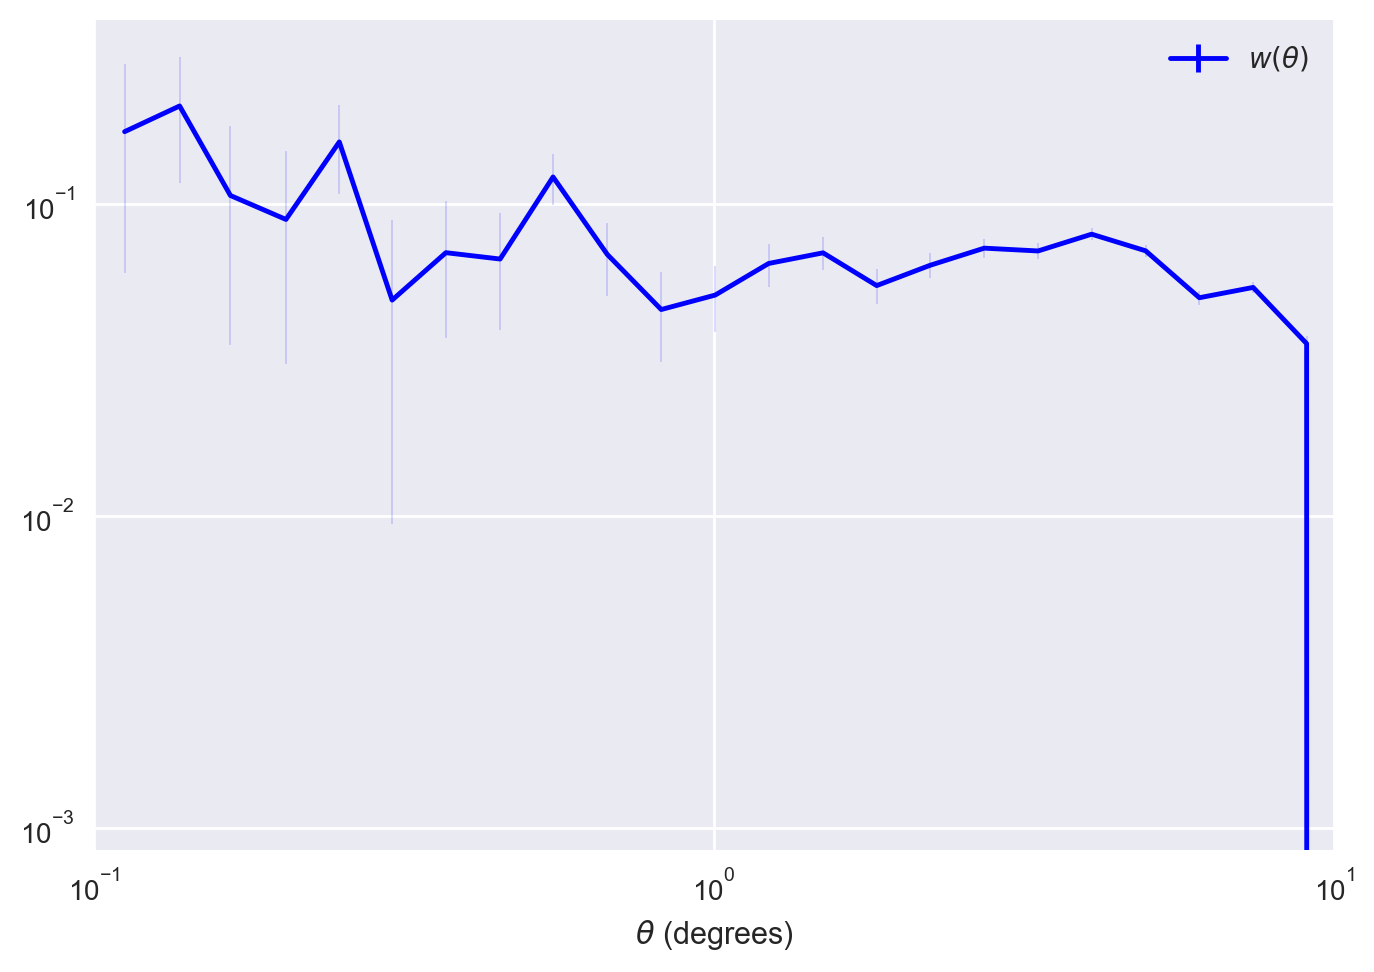

In [199]:
xi, varxi_1 = dd_1.calculateXi(rr_1)
r = numpy.exp(dd_1.meanlogr)
sig = numpy.sqrt(varxi_1)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='upper right')
plt.xlim([0.1,10])
plt.show()

In [200]:
dd_1 = treecorr.NNCorrelation(min_sep=0.1, max_sep=10, bin_size=0.2, sep_units='degrees')
dd_1.process(cat2)

In [201]:
leng_1 = len(RA_cat_2)
ra_min = np.min(cat1.ra)
ra_max = np.max(cat1.ra)
dec_min = np.min(cat1.dec)
dec_max = np.max(cat1.dec)

rand_ra_1 = np.random.uniform(ra_min, ra_max, leng_1) #Random RA
rand_sindec_1 = np.random.uniform(np.sin(dec_min), np.sin(dec_max), leng_1)
rand_dec_1 = np.arcsin(rand_sindec_1)

In [202]:
rand_1 = treecorr.Catalog(ra=rand_ra_1, dec=rand_dec_1, ra_units='radians', dec_units='radians')
rr_1 = treecorr.NNCorrelation(min_sep=0.1, max_sep=10, bin_size=0.2, sep_units='degrees')
rr_1.process(rand_1)

         Probably max_sep is larger than your field.


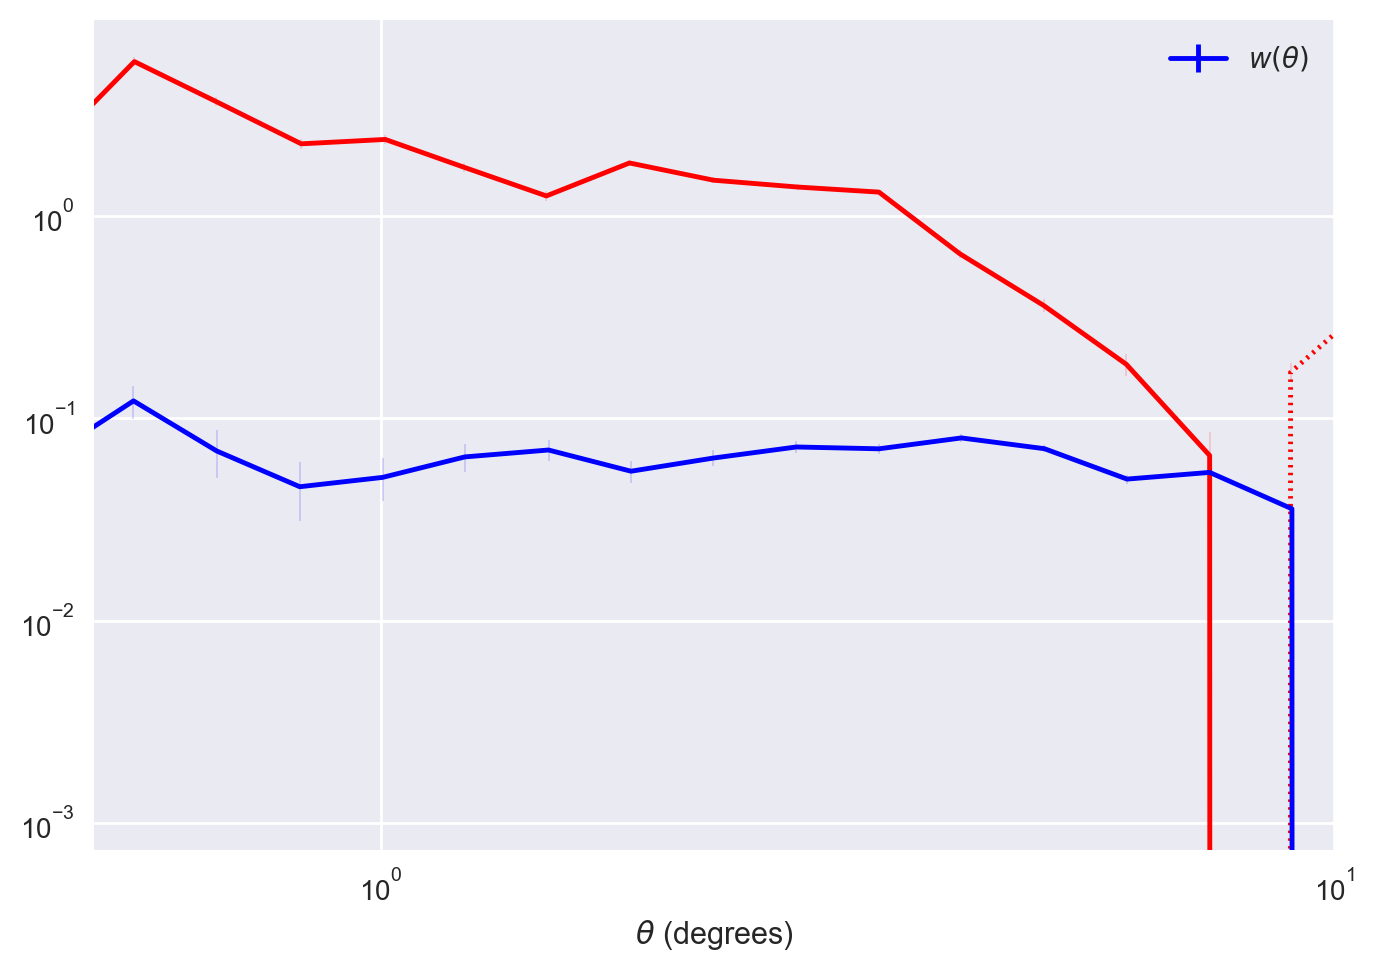

In [204]:
xi_2, varxi_2 = dd_1.calculateXi(rr_1)
r_2 = numpy.exp(dd_1.meanlogr)
sig_2 = numpy.sqrt(varxi_2)

plt.plot(r_2, xi_2, color='red')
plt.plot(r_2, -xi_2, color='red', ls=':')
plt.errorbar(r_2[xi_2>0], xi_2[xi_2>0], yerr=sig_2[xi_2>0], color='red', lw=0.1, ls='')
plt.errorbar(r_2[xi_2<0], -xi_2[xi_2<0], yerr=sig_2[xi_2<0], color='red', lw=0.1, ls='')
leg = plt.errorbar(-r_2, xi_2, yerr=sig_2, color='red')


plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')


plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='upper right')
plt.xlim([0.5,10])
plt.show()

### Split in three categories now

In [205]:
kmeans = KMeans(3) #Initialize a KMeans model with three clusters

# Fit and predict the labels of the clusters
labels = kmeans.fit_predict(X_posit)

# Get the three cluster centers
centers = kmeans.cluster_centers_

In [206]:
# Category 1
RA_new_1 = RA_posit[(labels==0)]
DEC_new_1 = DEC_posit[(labels==0)]

# Category 2

RA_new_2 = RA_posit[(labels==1)]
DEC_new_2 = DEC_posit[(labels==1)]

# Category 3

RA_new_3 = RA_posit[(labels==2)]
DEC_new_3 = DEC_posit[(labels==2)]


print(len(RA_new_1))
print(len(RA_new_2))
print(len(RA_new_3))

1536
114
460


In [207]:
np.savetxt('Fornax_new_cat_1.dat', np.c_[RA_new_1, DEC_new_1], fmt='%.6f %.6f')
np.savetxt('Fornax_new_cat_2.dat', np.c_[RA_new_2, DEC_new_2], fmt='%.6f %.6f')
np.savetxt('Fornax_new_cat_3.dat', np.c_[RA_new_3, DEC_new_3], fmt='%.6f %.6f')

In [208]:
# Create catalog. For now, we choose our catalog to be the objects classified as real LSB objects 
cat1 = treecorr.Catalog(ra=RA_new_1, dec=DEC_new_1, ra_units='deg', dec_units='deg')

dd_1 = treecorr.NNCorrelation(min_sep=0.1, max_sep=10, bin_size=0.2, sep_units='degrees')
dd_1.process(cat1)

leng_1 = len(RA_new_1)
ra_min = np.min(cat1.ra)
ra_max = np.max(cat1.ra)
dec_min = np.min(cat1.dec)
dec_max = np.max(cat1.dec)

rand_ra_1 = np.random.uniform(ra_min, ra_max, leng_1) #Random RA
rand_sindec_1 = np.random.uniform(np.sin(dec_min), np.sin(dec_max), leng_1)
rand_dec_1 = np.arcsin(rand_sindec_1)

rand_1 = treecorr.Catalog(ra=rand_ra_1, dec=rand_dec_1, ra_units='radians', dec_units='radians')
rr_1 = treecorr.NNCorrelation(min_sep=0.1, max_sep=10, bin_size=0.2, sep_units='degrees')
rr_1.process(rand_1)

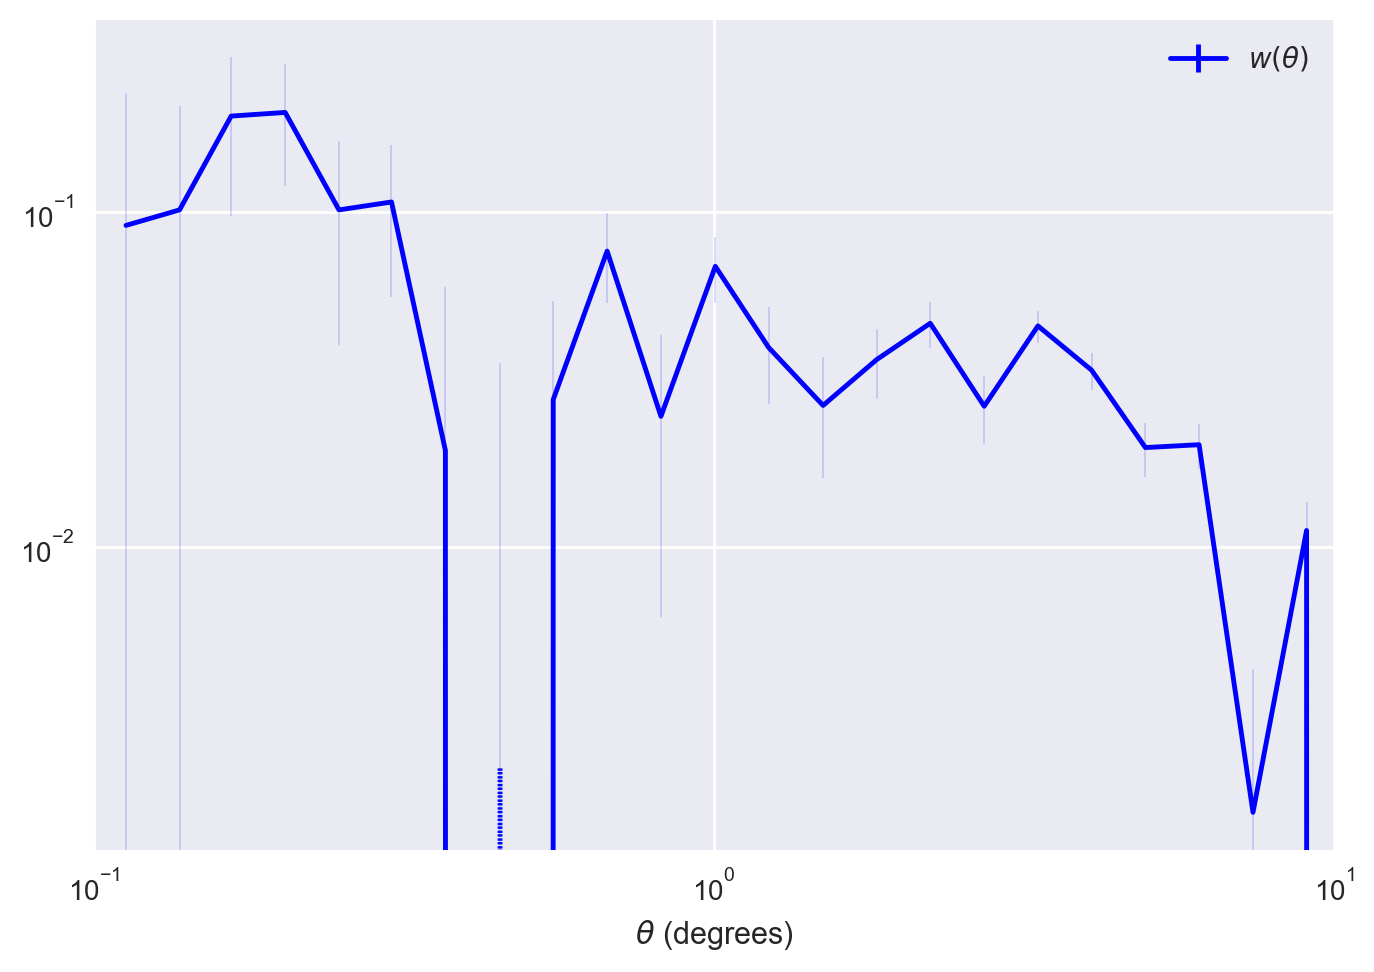

In [209]:
xi, varxi_1 = dd_1.calculateXi(rr_1)
r = numpy.exp(dd_1.meanlogr)
sig = numpy.sqrt(varxi_1)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='upper right')
plt.xlim([0.1,10])
plt.show()

In [210]:
# Create catalog. For now, we choose our catalog to be the objects classified as real LSB objects 
cat1 = treecorr.Catalog(ra=RA_new_2, dec=DEC_new_2, ra_units='deg', dec_units='deg')

dd_1 = treecorr.NNCorrelation(min_sep=0.1, max_sep=10, bin_size=0.2, sep_units='degrees')
dd_1.process(cat1)

leng_1 = len(RA_new_2)
ra_min = np.min(cat1.ra)
ra_max = np.max(cat1.ra)
dec_min = np.min(cat1.dec)
dec_max = np.max(cat1.dec)

rand_ra_1 = np.random.uniform(ra_min, ra_max, leng_1) #Random RA
rand_sindec_1 = np.random.uniform(np.sin(dec_min), np.sin(dec_max), leng_1)
rand_dec_1 = np.arcsin(rand_sindec_1)

rand_1 = treecorr.Catalog(ra=rand_ra_1, dec=rand_dec_1, ra_units='radians', dec_units='radians')
rr_1 = treecorr.NNCorrelation(min_sep=0.1, max_sep=10, bin_size=0.2, sep_units='degrees')
rr_1.process(rand_1)

         Probably max_sep is larger than your field.


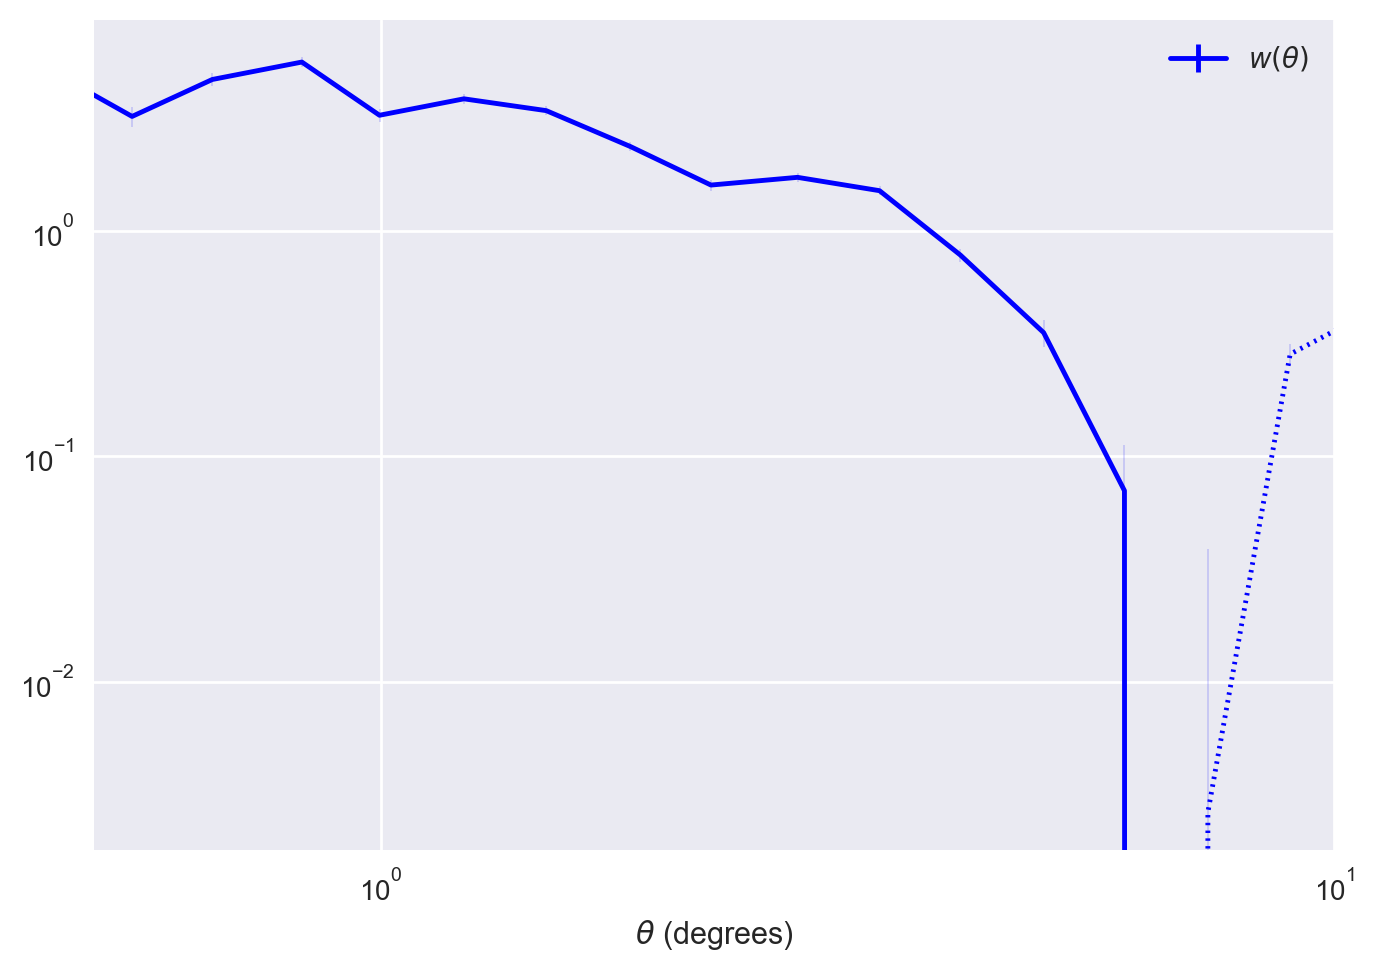

In [212]:
xi, varxi_1 = dd_1.calculateXi(rr_1)
r = numpy.exp(dd_1.meanlogr)
sig = numpy.sqrt(varxi_1)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='upper right')
plt.xlim([0.5,10])
plt.show()

In [213]:
# Create catalog. For now, we choose our catalog to be the objects classified as real LSB objects 
cat1 = treecorr.Catalog(ra=RA_new_3, dec=DEC_new_3, ra_units='deg', dec_units='deg')

dd_1 = treecorr.NNCorrelation(min_sep=0.1, max_sep=10, bin_size=0.2, sep_units='degrees')
dd_1.process(cat1)

leng_1 = len(RA_new_3)
ra_min = np.min(cat1.ra)
ra_max = np.max(cat1.ra)
dec_min = np.min(cat1.dec)
dec_max = np.max(cat1.dec)

rand_ra_1 = np.random.uniform(ra_min, ra_max, leng_1) #Random RA
rand_sindec_1 = np.random.uniform(np.sin(dec_min), np.sin(dec_max), leng_1)
rand_dec_1 = np.arcsin(rand_sindec_1)

rand_1 = treecorr.Catalog(ra=rand_ra_1, dec=rand_dec_1, ra_units='radians', dec_units='radians')
rr_1 = treecorr.NNCorrelation(min_sep=0.1, max_sep=10, bin_size=0.2, sep_units='degrees')
rr_1.process(rand_1)

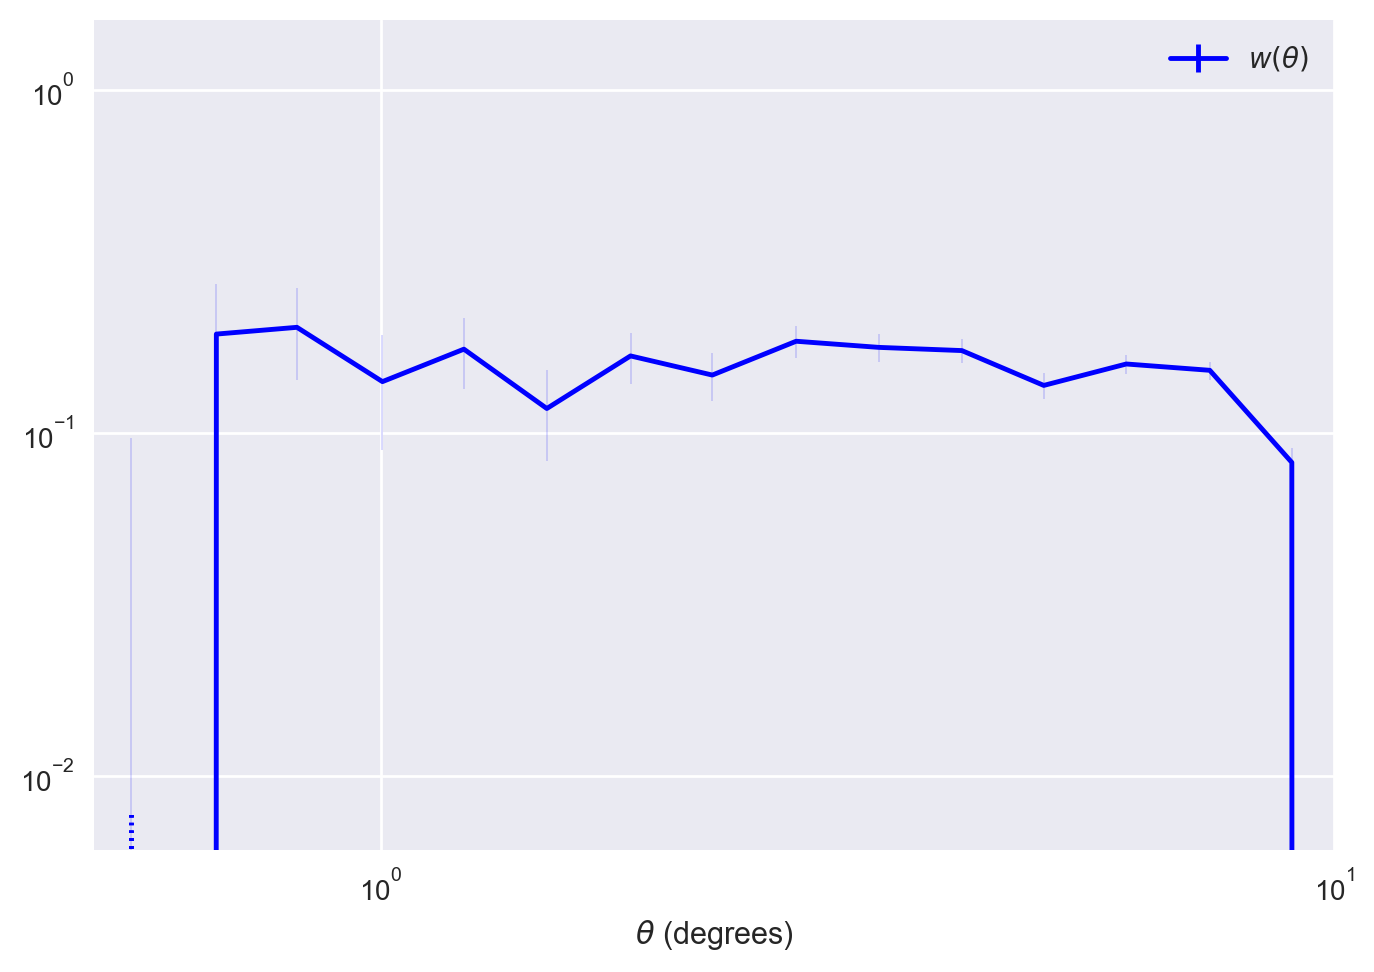

In [214]:
xi, varxi_1 = dd_1.calculateXi(rr_1)
r = numpy.exp(dd_1.meanlogr)
sig = numpy.sqrt(varxi_1)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='upper right')
plt.xlim([0.5,10])
plt.show()

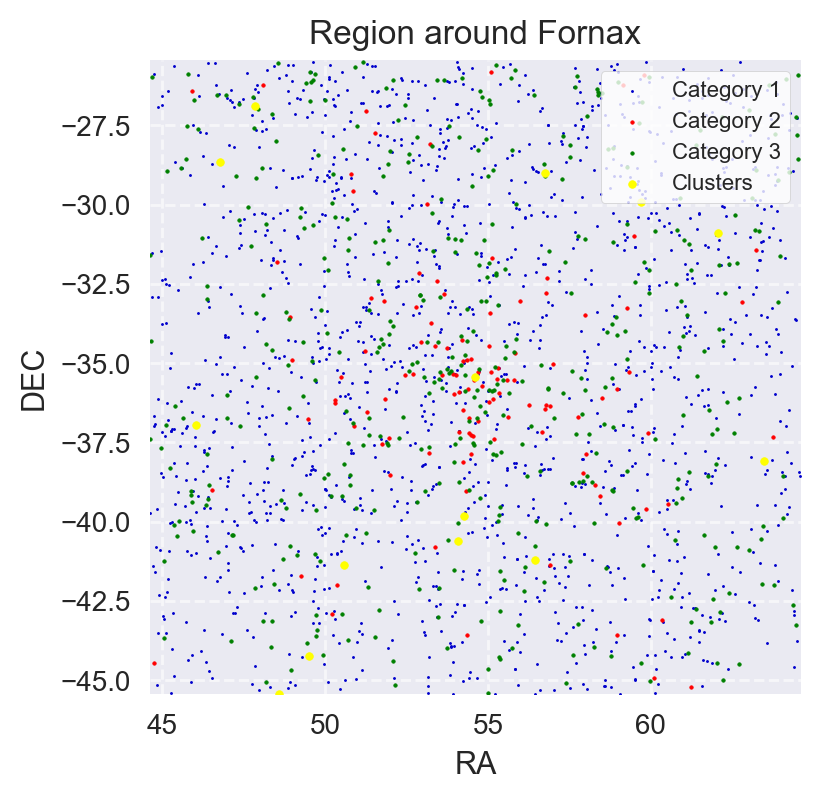

In [217]:
fig = plt.figure(figsize=(4.2,4.2))
plt.scatter(RA_new_1, DEC_new_1, c='mediumblue', s=0.5,  label='Category 1')
plt.scatter(RA_new_2, DEC_new_2, c='red', s=1.5,  label='Category 2')
plt.scatter(RA_new_3, DEC_new_3, c='green', s=1.5,  label='Category 3')
plt.scatter(RA_reflex, DEC_reflex, c='yellow', s=7.4, label='Clusters')


plt.xlabel('RA'); plt.ylabel('DEC')
plt.grid(ls='--', alpha=0.6)
plt.xlim(44.61625,64.61625)
plt.ylim(-45.44833,-25.44833)
plt.legend(frameon=True, loc='upper right', fontsize=8, facecolor='w')
plt.title('Region around Fornax')
plt.show()